from IPython.display import display, Markdown

equation = r"""
$$
h(x, y, t) = h_{max} \left\{ \exp\left[ -\frac{\pi^2 K t}{S_s} \left( \frac{1}{X^2} + \frac{1}{Y^2} \right) \right] \sin \left( \frac{\pi x}{X} \right) \sin \left( \frac{\pi y}{Y} \right) \right\}
$$
"""

display(Markdown(equation))
from IPython.display import display, Markdown

equation = r"""
$$
U = \frac{K h_{max} \pi}{X} \left\{ \exp \left[ -\frac{\pi^2 K t}{S_s} \left( \frac{1}{X^2} + \frac{1}{Y^2} \right) \right] \cos \left( \frac{\pi x}{X} \right) \sin \left( \frac{\pi y}{Y} \right) \right\}
$$
"""

display(Markdown(equation))
from IPython.display import display, Markdown

equation = r"""
$$
V = \frac{K h_{max} \pi}{Y} \left\{ \exp \left[ -\frac{\pi^2 K t}{S_s} \left( \frac{1}{X^2} + \frac{1}{Y^2} \right) \right] \sin \left( \frac{\pi x}{X} \right) \cos \left( \frac{\pi y}{Y} \right) \right\}
$$
"""

display(Markdown(equation))

In [1]:
import underworld3 as uw
import numpy as np
import matplotlib.pyplot as plt
import sympy

fatal: not a git repository (or any of the parent directories): .git


#### Input specifications

Parameters required for the solution
Domain length = X
Domain width = Y
Hydraulic conductivity = K
Specific storage = Ss
Maximum head = hmax

In [2]:
length = 2000.0  # meters
width = 1000.0  # meters
K = 3.0e-3  # m/yr
Ss = 2.3e-4  # m^-1
hmax = 100.0  # meters

resolution = 32

# Constants
X = 2000.0  # meters
Y = 1000.0  # meters
K = 3.0e-3  # m/yr
Ss = 2.3e-4  # m^-1
hmax = 100.0  # meters

# Example usage
x = 1000.0  # meters
y = 500.0  # meters
t = 10000  # years
qdeg = 3
Vdeg = 2
Hdeg = 1

#### Compting hydraulic head (h)

In [3]:
import numpy as np

def compute_h(x, y, t, length, width, K, Ss, hmax):
    pi = np.pi
    exponent = -((pi**2 * K * t) / Ss)
    term1 = np.exp((exponent) * ((1 / (length**2)) + (1 / (width**2))))
    term2 = np.sin((pi * x) / length) * np.sin((pi * y) / width)
    h = hmax * term1 * term2
    return h



In [4]:
computed_h = compute_h(x, y, t, length, width, K, Ss, hmax)
print(f"Computed h({x}, {y}, {t}): {computed_h} meters")

Computed h(1000.0, 500.0, 10000): 20.00526632966812 meters


In [5]:
x = 1000.0  # meters
y = 500.0  # meters
t = 10000  # years

computed_h = compute_h(x, y, t, X, Y, K, Ss, hmax)
print (computed_h)

20.00526632966812


#### Computing Velocity

In [27]:
def compute_vel(x, y, t, length, width, K, Ss, hmax):
    pi = np.pi
    exponent = -(pi**2 * K * t) / Ss
    
    # Compute the amplitude factors
    amp1 = (K * hmax * pi) / length
    amp2 = (K * hmax * pi) / width

    # Velocity components based on the provided equations
    u = amp1 * np.exp(exponent * (1 / length**2 + 1 / width**2)) * np.cos(pi * x / length) * np.sin(pi * y / width)
    v = amp2 * np.exp(exponent * (1 / length**2 + 1 / width**2)) * np.sin(pi * x / length) * np.cos(pi * y / width)

    return u, v


In [29]:
xmin, xmax = 0, length
ymin, ymax = 0, width

In [30]:
resolution

32

In [31]:
length/256

7.8125

In [32]:
length / resolution

62.5

#### Defining mesh

In [33]:
meshbox = uw.meshing.UnstructuredSimplexBox(
                                                minCoords= (xmin, ymin),
                                                maxCoords= (xmax, ymax),
                                                cellSize= length / resolution,
                                                regular=False,
                                                qdegree = qdeg
                                        )

#### Creating analytical mesh vaiables

In [34]:
#Create mesh variables

v_soln  = uw.discretisation.MeshVariable("U", meshbox, meshbox.dim, degree = Vdeg)
h_soln  = uw.discretisation.MeshVariable("P", meshbox, 1, degree = Hdeg)

v  = uw.discretisation.MeshVariable("V", meshbox, meshbox.dim, degree = Vdeg)

with meshbox.access(v):
 v.data[:] = 0.0

#### Solving the analytical variables

In [36]:
with meshbox.access(h_soln, v_soln):
    for (i, (x, y)) in enumerate(h_soln.coords):
        #print(x, y)
        h_soln.data[i] = compute_h(x = x, y = y, t = t,length = length, width = width, K = K, Ss = Ss, hmax = hmax)
        
    for (i, (x, y)) in enumerate(v_soln.coords):
        v_soln.data[i, :] = compute_vel(x = x, y = y, t =t, length = length, width = width, K = K, Ss = Ss, hmax = hmax)

    print(h_soln.data.min(), h_soln.data.max())
    print(v_soln.data[:, 0].min(), v_soln.data[:, 0].max())
    print(v_soln.data[:, 1].min(), v_soln.data[:, 1].max())


0.0 19.96486258297641
-9.427259660158891e-05 9.427259660158891e-05
-0.00018854519320317783 0.00018854519320317783


In [38]:
xv = meshbox.N.x 
yv = meshbox.N.y

#### Creating numerical mesh variables

In [39]:
# u_num and v_num are the numerical solutions

u_num  = uw.discretisation.MeshVariable("Un", meshbox, 1, degree=Vdeg)
v_num  = uw.discretisation.MeshVariable("Vn", meshbox, 1, degree=Vdeg)

In [40]:
h_num = uw.discretisation.MeshVariable("H", meshbox, 1, degree= Hdeg)
vel_num  = uw.discretisation.MeshVariable("V2", meshbox, meshbox.dim, degree = Vdeg)
# darcy_solver = uw.systems.SteadyStateDarcy(
#                                             mesh = meshbox,
#                                             h_Field = h_num2,
#                                             v_Field = v_num2,
#                                             solver_name = "darcy-ss",
#                                             verbose = True
#                                         )
# darcy_solver.constitutive_model = uw.constitutive_models.DarcyFlowModel
# darcy_solver.constitutive_model.Parameters.permeability = 1
# darcy_solver.petsc_options.delValue("ksp_monitor")

# xv, yv = meshbox.X
# # darcy_solver.add_dirichlet_bc([height + xv * sympy.tan(alpha_rad)], "Top")
# darcy_solver.add_dirichlet_bc(0., "Top")
# darcy_solver.add_dirichlet_bc(0., "Bottom")
# darcy_solver.add_dirichlet_bc(0., "Left")
# darcy_solver.add_dirichlet_bc(0., "Right")

In [41]:
print (h_num)

_MeshVariable instance 6, <underworld3.discretisation._MeshVariable object at 0x177360d50>


In [42]:
# darcy_solver.constitutive_model.Parameters.s = sympy.Matrix([0, 0]).T

In [43]:
# darcy_solver.solve()

In [44]:
# with meshbox.access(h_num2):
#     fig, ax = plt.subplots(dpi = 150)
#     ax.scatter(h_num2.coords[:, 0], h_num2.coords[:, 1], c = h_num2.data[:], s = 10)
#     ax.set_aspect("equal")

In [45]:
# with meshbox.access(v_num2):
#     fig, ax = plt.subplots(dpi = 100)
#     out = ax.scatter(v_num2.coords[:, 0], v_num2.coords[:, 1], c = v_num2.data[:,0], s = 20)
#     ax.set_aspect("equal")
#     cbar = fig.colorbar(out)
#     ax.set_title("Numerical solution for U")
 
#     fig, ax = plt.subplots(dpi = 100)
#     out2 = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 0], s = 20)
#     ax.set_aspect("equal")
#     cbar2 = fig.colorbar(out2)
#     ax.set_title("Analytical solution for U")

In [46]:
# with meshbox.access(v_num2):
#     fig, ax = plt.subplots(dpi = 100)
#     out = ax.scatter(v_num2.coords[:, 0], v_num2.coords[:, 1], c = v_num2.data[:,1], s = 20)
#     ax.set_aspect("equal")
#     cbar = fig.colorbar(out)
#     ax.set_title("Numerical solution for V")
 
#     fig, ax = plt.subplots(dpi = 100)
#     out2 = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 1], s = 20)
#     ax.set_aspect("equal")
#     cbar2 = fig.colorbar(out2)
#     ax.set_title("Analytical solution for V")

In [47]:
with meshbox.access(h_num):
    for (i, (x, y)) in enumerate(h_num.coords):
        #print(x, y)
        h_num.data[i] = compute_h(x = x, y = y, t = 0,length = length, width = width, K = K, Ss = Ss, hmax = hmax)
    

In [48]:
# u_num and v_num are the numerical solutions
#u_num  = uw.discretisation.MeshVariable("Un", meshbox, 1, degree = Vdeg)
#v_num  = uw.discretisation.MeshVariable("Vn", meshbox, 1, degree = Vdeg)
 
u_calc = uw.systems.Projection(meshbox, u_num)
u_calc.uw_function = K * sympy.diff(h_num.sym, xv)
u_calc.uw_function
 
v_calc = uw.systems.Projection(meshbox, v_num)
v_calc.uw_function = K * sympy.diff(h_num.sym, yv)
v_calc.uw_function



Matrix([[0.003*{H}_{,1}(N.x, N.y)]])

#### Create the advDiff solver

In [49]:


adv_diff = uw.systems.AdvDiffusionSLCN(
    meshbox,
    u_Field=h_num,
    V_fn=v.sym,
    #solver_name="adv_diff",
)


#### Set boundary conditions

In [50]:
adv_diff.add_dirichlet_bc(0., "Top")
adv_diff.add_dirichlet_bc(0., "Bottom")
adv_diff.add_dirichlet_bc(0., "Left")
adv_diff.add_dirichlet_bc(0., "Right")

In [51]:
print (K/Ss)

13.043478260869565


In [52]:
# ### Set up properties of the adv_diff solver
# - Constitutive model (Diffusivity)
# - Boundary conditions
# - Internal velocity
# - Initial temperature distribution 

adv_diff.constitutive_model = uw.constitutive_models.DiffusionModel
adv_diff.constitutive_model.Parameters.diffusivity = K/Ss

adv_diff.constitutive_model.Parameters.diffusivity.value

adv_diff.add_dirichlet_bc((0.), "Top")
adv_diff.add_dirichlet_bc((0.), "Bottom")
adv_diff.add_dirichlet_bc((0.), "Left")
adv_diff.add_dirichlet_bc((0.), "Right")


# print(adv_diff.estimate_dt())
# steps = int(dt // (12*adv_diff.estimate_dt()[1]))

/Users/sruthysajeev/Documents/codes/uw3-local-installation/uw3_folder/src/underworld3/function/expressions.py:243: UserWarning: DEPRECATION warning, don't use 'value' attribute for expression: UWexpression instance 40, { \upkappa \hspace{ 0.01pt } }, please use 'sym' attribute
  warnings.warn(


In [54]:
steps = 10
final_time = 10000
dt = final_time / steps  
model_time = 0

for step in range(steps):  
    adv_diff.solve(timestep=dt, zero_init_guess=False)
    model_time += dt
    print(f"Timestep: {step + 1}/{steps}, model time {model_time}")


Timestep: 1/10, model time 1000.0
Timestep: 2/10, model time 2000.0
Timestep: 3/10, model time 3000.0
Timestep: 4/10, model time 4000.0
Timestep: 5/10, model time 5000.0
Timestep: 6/10, model time 6000.0
Timestep: 7/10, model time 7000.0
Timestep: 8/10, model time 8000.0
Timestep: 9/10, model time 9000.0
Timestep: 10/10, model time 10000.0


In [91]:
v_calc.solve()

In [92]:
u_calc.solve()

In [94]:
sympy.sqrt(v_soln.sym.dot(v_soln.sym))

sqrt({U}_{ 0 }(N.x, N.y)**2 + {U}_{ 1 }(N.x, N.y)**2)

In [106]:
if uw.mpi.size == 1:

        import pyvista as pv
        import underworld3.visualisation as vis

        pvmeshbox = vis.mesh_to_pv_mesh(meshbox)
        pvmeshbox.point_data["V"] = vis.vector_fn_to_pv_points(pvmeshbox, v_soln.sym)
        pvmeshbox.point_data["Vmag"] = vis.scalar_fn_to_pv_points(pvmeshbox, sympy.sqrt(v_soln.sym.dot(v_soln.sym)))
        pvmeshbox.point_data["T"] = vis.scalar_fn_to_pv_points(pvmeshbox, h_soln.sym)
        
        pl = pv.Plotter()

        pl.add_mesh(
            pvmeshbox,
            cmap="coolwarm",
            edge_color="Black",
            show_edges=True,
            scalars="T",
            use_transparency=False,
            show_scalar_bar=False,
            opacity=1,
        )



        # pl.add_points(T_points, color="White",
        #               scalars="dT", cmap="coolwarm",
        #               point_size=5.0, opacity=0.5)


        pl.add_arrows(pvmeshbox.points, pvmeshbox.point_data["V"], mag=1e-6, opacity=1, show_scalar_bar=False)

        # pl.add_points(pdata)

        pl.show(cpos="xy")

        # return vsol

#T_points.point_data["dT"].max()

adv_diff

adv_diff.F1

Widget(value='<iframe src="http://localhost:56629/index.html?ui=P_0x2c3350110_16&reconnect=auto" class="pyvist…

${ \mathbf{F}_1\left( \mathbf{u} \right) \hspace{ 0.69pt } }$

In [96]:
with meshbox.access():
    print(v_soln.data[:, 0].max())
    print(v_soln.data[:, 0].min())

9.427259660158891e-05
-9.427259660158891e-05


In [97]:
with meshbox.access():
    print(h_soln.data.max())
    print(h_soln.data.min())
    print(h_num.data.max())
    print(h_num.data.min())

    

19.96486258297641
0.0
19.84647748839834
0.0


In [101]:
with meshbox.access(vel_num, u_num, v_num):

    vel_num.data [:,0] = u_num.data [:,0]
    vel_num.data [:,1] = v_num.data [:,0]

In [102]:
import pyvista as pv
import underworld3.visualisation as vis

pl = pv.Plotter(window_size=(750, 750))

velocity_points = vis.meshVariable_to_pv_cloud(v_soln)
velocity_points.point_data["V"] = vis.vector_fn_to_pv_points(velocity_points, v_soln.sym)

if uw.mpi.size == 1:

    import pyvista as pv
    import underworld3.visualisation as vis

    pvmesh = vis.mesh_to_pv_mesh(meshbox)
    pvmesh.point_data["P"] = vis.scalar_fn_to_pv_points(pvmesh, h_soln.sym)
    #pvmesh.point_data["K"] = vis.scalar_fn_to_pv_points(pvmesh, kFunc)
    pvmesh.point_data["V"] = vis.vector_fn_to_pv_points(pvmesh, v_soln.sym)

pl = pv.Plotter(window_size=(750, 750))

pl.add_mesh(
    pvmesh,
    cmap="coolwarm",
    edge_color="Black",
    show_edges=True,
    scalars="P",
    use_transparency=False,
    opacity=1,
)

#pl.add_mesh(pvstream, line_width=1.0)

pl.add_arrows(velocity_points.points[::2], velocity_points.point_data["V"][::2], mag=1000000, opacity=1)

pl.show(cpos="xy")
pl.camera.zoom(1)
pl.screenshot("/Users/sruthysajeev/Documents/codes/uw3-codes/Prblms/ff2/ff2_test2ana.png", scale = 3.5)

Widget(value='<iframe src="http://localhost:56629/index.html?ui=P_0x2a2989350_12&reconnect=auto" class="pyvist…

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [100]:
import pyvista as pv
import underworld3.visualisation as vis

pl = pv.Plotter(window_size=(750, 750))

velocity_points = vis.meshVariable_to_pv_cloud(vel_num)
velocity_points.point_data["V"] = vis.vector_fn_to_pv_points(velocity_points, vel_num.sym)

if uw.mpi.size == 1:

    import pyvista as pv
    import underworld3.visualisation as vis

    pvmesh = vis.mesh_to_pv_mesh(meshbox)
    pvmesh.point_data["P"] = vis.scalar_fn_to_pv_points(pvmesh, h_num.sym)
    #pvmesh.point_data["K"] = vis.scalar_fn_to_pv_points(pvmesh, kFunc)
    pvmesh.point_data["V"] = vis.vector_fn_to_pv_points(pvmesh, vel_num.sym)

pl = pv.Plotter(window_size=(750, 750))

pl.add_mesh(
    pvmesh,
    cmap="coolwarm",
    edge_color="Black",
    show_edges=True,
    scalars="P",
    use_transparency=False,
    opacity=1,
)

#pl.add_mesh(pvstream, line_width=1.0)

pl.add_arrows(velocity_points.points[::2], velocity_points.point_data["V"][::2], mag=1000000, opacity=1)

pl.show(cpos="xy")
pl.camera.zoom(1)
pl.screenshot("/Users/sruthysajeev/Documents/codes/uw3-codes/Prblms/ff2/ff2_test2num.png", scale = 3.5)

Widget(value='<iframe src="http://localhost:56629/index.html?ui=P_0x2a7041610_10&reconnect=auto" class="pyvist…

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [65]:
with meshbox.access():
    print(v_soln.data[:, 0].max())
    print(v_soln.data[:, 0].min())

9.427259660158891e-05
-9.427259660158891e-05


In [66]:
with meshbox.access():
    print(v_soln.data[:, 1].max())
    print(v_soln.data[:, 1].min())

0.00018854519320317783
-0.00018854519320317783


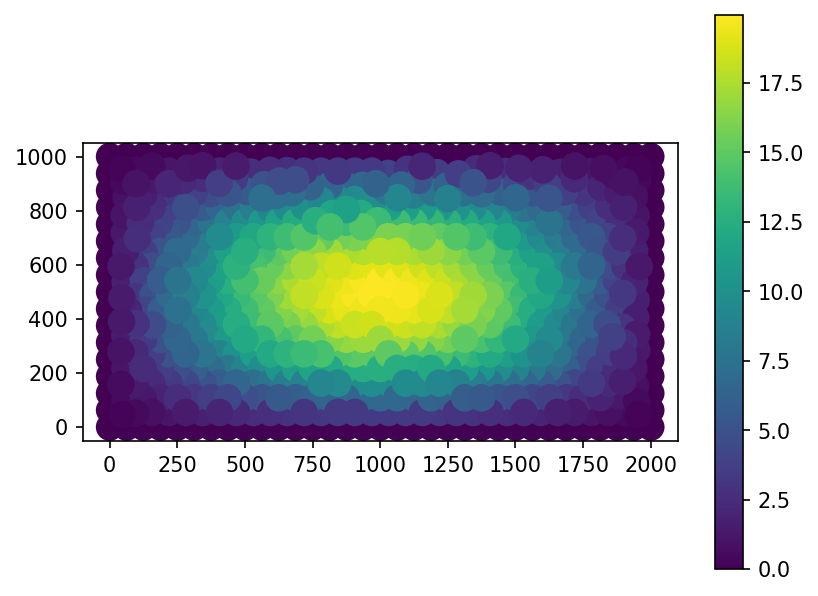

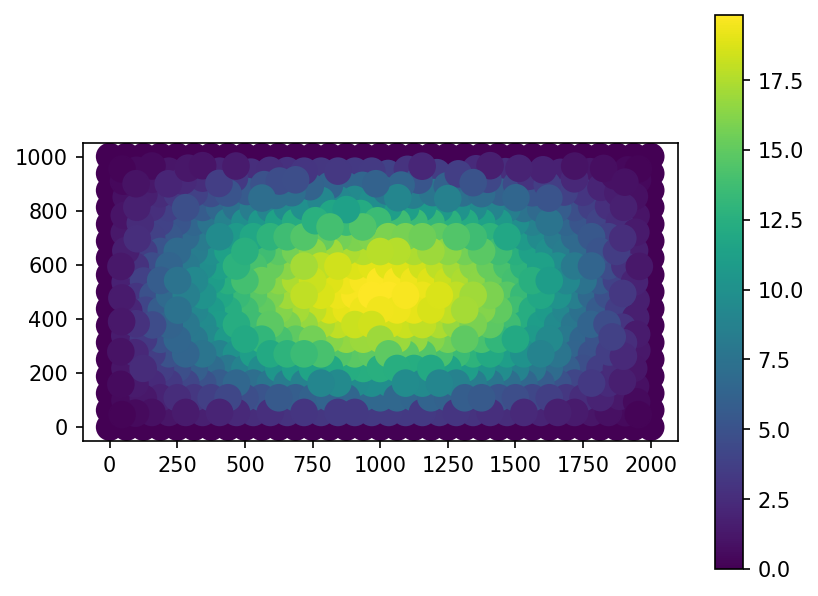

In [67]:
with meshbox.access(h_soln):
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(h_soln.coords[:, 0], h_soln.coords[:, 1], c = h_soln.data[:], s = 150)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)
    
with meshbox.access(h_num):
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(h_num.coords[:, 0], h_num.coords[:, 1], c = h_num.data[:], s = 150)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)

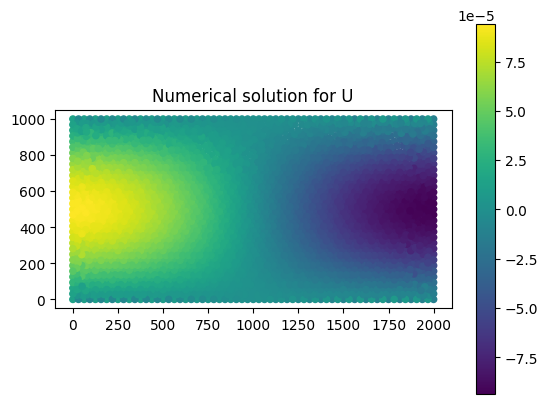

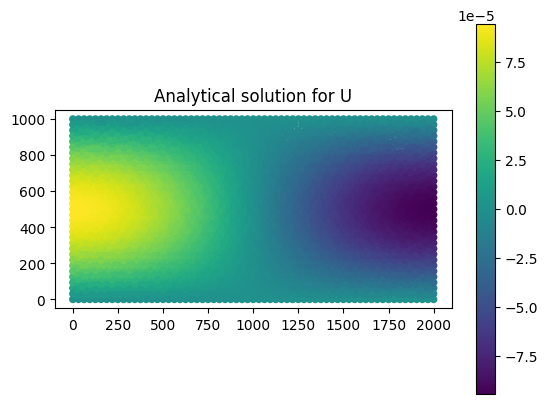

In [68]:
with meshbox.access(u_num):
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(u_num.coords[:, 0], u_num.coords[:, 1], c = u_num.data[:,0], s = 20)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)
    ax.set_title("Numerical solution for U")
 
    fig, ax = plt.subplots(dpi = 100)
    out2 = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 0], s = 20)
    ax.set_aspect("equal")
    cbar2 = fig.colorbar(out2)
    ax.set_title("Analytical solution for U")

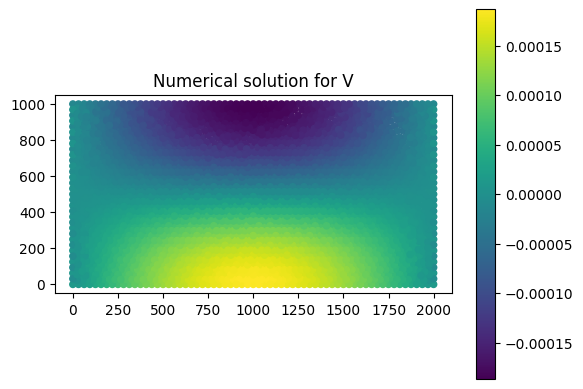

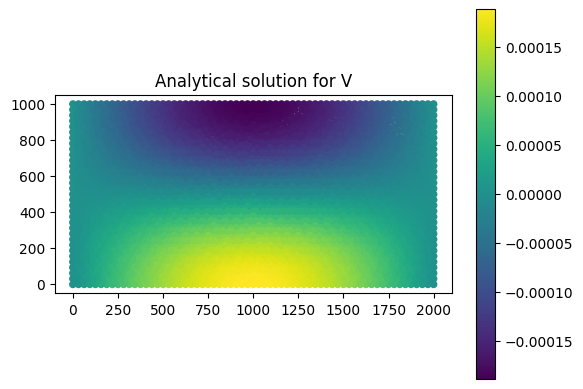

In [69]:
with meshbox.access(v_num):
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(v_num.coords[:, 0], v_num.coords[:, 1], c = v_num.data[:,0], s = 20)
    ax.set_aspect("equal")
    cbar = fig.colorbar(out)
    ax.set_title("Numerical solution for V")
 
    fig, ax = plt.subplots(dpi = 100)
    out2 = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 1], s = 20)
    ax.set_aspect("equal")
    cbar2 = fig.colorbar(out2)
    ax.set_title("Analytical solution for V")

In [70]:
import pyvista as pv
import underworld3.visualisation as vis

pl = pv.Plotter(window_size=(750, 750))

In [71]:
velocity_points = vis.meshVariable_to_pv_cloud(v_soln)
velocity_points.point_data["V"] = vis.vector_fn_to_pv_points(velocity_points, v_soln.sym)

In [72]:
with meshbox.access(vel_num, u_num, v_num):

    vel_num.data [:,0] = u_num.data [:,0]
    vel_num.data [:,1] = v_num.data [:,0]

#### L2 norm calculation
L2 norm calculation for v and h for different cell size

In [73]:
#l2 norm calculation

import math
def calculate_vec_h_norm():
    #sympy functions corresponding to integrals
    vec_diff = v_soln.sym - vel_num.sym
    vec_diff_mag = vec_diff.dot(vec_diff)

    vec_ana_mag = v_soln.sym.dot(v_soln.sym)

    vec_diff_mag_integ = math.sqrt(uw.maths.Integral(meshbox, vec_diff_mag).evaluate())
    vec_ana_mag_integ = math.sqrt(uw.maths.Integral(meshbox, vec_ana_mag).evaluate())
    vec_norm = vec_diff_mag_integ / vec_ana_mag_integ

    h_diff = (h_soln.sym - h_num.sym)**2
    h_ana_sq = h_soln.sym**2
    h_diff_integ = math.sqrt(uw.maths.Integral(meshbox, h_diff).evaluate())
    h_ana_sq_integ = math.sqrt(uw.maths.Integral(meshbox, h_ana_sq).evaluate())
    h_norm = h_diff_integ/h_ana_sq_integ
    return vec_norm, h_norm

In [74]:
calculate_vec_h_norm()

(0.016035310563489735, 0.005984854951317343)

In [75]:
meshbox.get_min_radius()

24.02847481531693

In [76]:
#import numpy as np

# Calculate differences
#with meshbox.access(h_soln, h_num):
    #h_diff = h_soln.data[:] - h_num.data[:] 
#print(h_diff)

#### Get the number of cells (elements) in the mesh

In [77]:

num_cells = meshbox.data.shape[0]
print(f"Number of elements (cells) in the mesh: {num_cells}")



Number of elements (cells) in the mesh: 657


In [78]:
# Get the number of node points in the mesh
num_node_points = meshbox.data.shape[0]
print(f"Number of node points in the mesh: {num_node_points}")




Number of node points in the mesh: 657


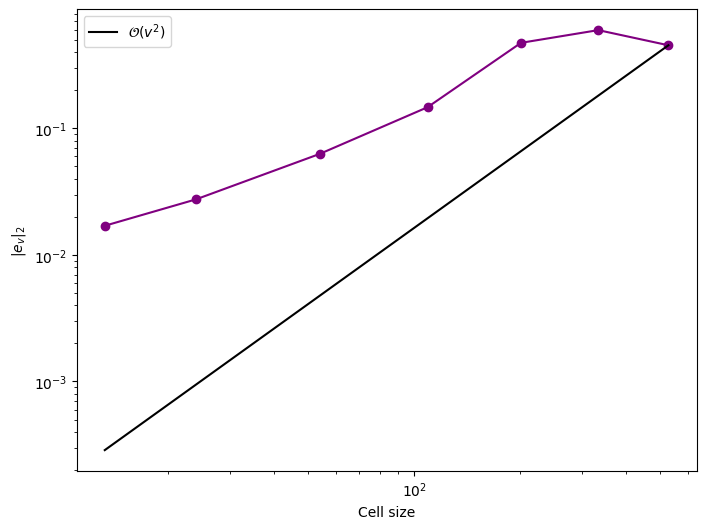

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Data
cell_size = [527.0462766947298, 333.3333333331935, 201.11999755874245, 
             109.22818795864026, 53.95733534287479, 24.02847481531693, 
             13.25678061259621]
v_norm = [0.4532600628897608, 0.5971237473004634, 0.47376604540273637, 
     0.14683885149113282, 0.06275316460527769, 0.02743882202772734, 
     0.016990447753729803]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Plot data with markers and line
ax.plot(cell_size, v_norm, marker='o', linestyle='-', color='purple')

# Set labels and title
ax.set_xlabel('Cell size')
ax.set_ylabel(r'$|e_v|_2$')

# Adding the theoretical convergence rate line for reference
# Assuming a convergence rate line proportional to h^3 for comparison
v_theoretical = np.linspace(min(cell_size), max(cell_size), 100)
convergence_rate = v_theoretical**2 * v_norm[0] / cell_size[0]**2  # Scale to fit initial point

ax.plot(v_theoretical, convergence_rate, 'k-', label=r'$\mathcal{O}(v^2)$')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [80]:
#l2 norm before update
#1
#(v-0.4532600628897608, h-0.31294633206013084),cs-527.0462766947298
#2
#(v-0.5971237473004634, h-0.40154740367910724),cs-333.3333333331935
#4
#(v-0.47376604540273637, h-0.3083924318298834),cs-201.11999755874245
#8
#(v-0.14683885149113282, h-0.08054544594236261)cs-109.22818795864026
#16
#(0.06275316460527769, 0.03403755831227602)cs-53.95733534287479
#32
#(0.02743882202772734, 0.019111728491912883)cs-24.02847481531693
#64
#(v-0.016990447753729803,h-0.01528481787910924)cs-13.25678061259621
#128
#(0.01432780538645858, 1.0)
#6.586625819840943


In [81]:

#8
#(v-0.11978262876368143, h-0.04070853337396394 cs-109.22818795864026)
#16
#(v-0.05057678268572133, h-0.022191733412819103, cs-53.95733534287479)
#32
#(v-0.023255942718317078,h-0.01620843438044385, cs-24.02847481531693)
#64
#(v-0.016087114215396096, h-0.014575457517655745, cs-13.25678061259621)
#128
#(v-0.014412494724580623 h-0.01414521313576454 cs-6.586625819840943)
#256
#(v-, h-, cs-)

In [82]:
#l2 norm using terminal
#8
#(v-0.11978262876368143, h-0.04070853337396394 cs-109.22818795864026)
#16
#(v-0.05057678268572133, h-0.022191733412819103, cs-53.957335342874
#32
#v-0.023251014608755213, h-0.016202402631671227 cs-24.02847481531693
#64
#v-0.016079158155093982, h-0.014542901888417404 cs-13.25678061259621
#128
#v-0.014410337677840926, h-0.01414303973157813 cs-6.586625819840943
#256
#v-0.014098136863675758, h-0.01404373902647193 cs-3.293895306251816
#512
#v-0.014030880431402614, h-0.014018300598501716 cs-1.6739275325169252)

In [83]:
#v=[(0.11978262876368143,0.05057678268572133,0.023251014608755213,0.016079158155093982,0.014410337677840926,0.014098136863675758)]
#h= [(0.04070853337396394,0.022191733412819103,0.016202402631671227,0.014542901888417404,0.01414303973157813 ,0.01404373902647193)]
#cs=(109.22818795864026,53.957335342874,24.02847481531693,13.25678061259621,6.586625819840943,3.293895306251816)

#### L2 norm plotting
Plotting l2 norm for h and v

In [84]:
pip install tabulate


DEPRECATION: Loading egg at /Users/sruthysajeev/Documents/codes/uw3-local-installation/uw3-env/lib/python3.11/site-packages/typeguard-4.1.5-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/sruthysajeev/Documents/codes/uw3-local-installation/uw3-env/lib/python3.11/site-packages/sympy-1.12-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/sruthysajeev/Documents/codes/uw3-local-installation/uw3-env/lib/python3.11/site-packages/xxhash-3.4.1-py3.11-macosx-14.0-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at ht

In [85]:
from tabulate import tabulate

# Data
L2_norm_v = [
    0.11978262876368143, 0.05057678268572133, 0.023251014608755213, 
    0.016079158155093982, 0.014410337677840926, 0.014098136863675758,0.014030880431402614
]
L2_norm_h = [
    0.04070853337396394, 0.022191733412819103, 0.016202402631671227, 
    0.014542901888417404, 0.01414303973157813, 0.01404373902647193,0.014018300598501716
]
cell_size = [
    109.22818795864026, 53.957335342874, 24.02847481531693, 
    13.25678061259621, 6.586625819840943, 3.293895306251816,1.6739275325169252
]
resolution = [8, 16, 32, 64, 128, 256, 512]

# Create the table
data = zip(resolution, cell_size, L2_norm_v, L2_norm_h)
headers = ["Resolution", "Cell Size", "v L2 Norm", "h L2 Norm"]

# Display the table
print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


╒══════════════╤═════════════╤═════════════╤═════════════╕
│   Resolution │   Cell Size │   v L2 Norm │   h L2 Norm │
╞══════════════╪═════════════╪═════════════╪═════════════╡
│            8 │   109.228   │   0.119783  │   0.0407085 │
├──────────────┼─────────────┼─────────────┼─────────────┤
│           16 │    53.9573  │   0.0505768 │   0.0221917 │
├──────────────┼─────────────┼─────────────┼─────────────┤
│           32 │    24.0285  │   0.023251  │   0.0162024 │
├──────────────┼─────────────┼─────────────┼─────────────┤
│           64 │    13.2568  │   0.0160792 │   0.0145429 │
├──────────────┼─────────────┼─────────────┼─────────────┤
│          128 │     6.58663 │   0.0144103 │   0.014143  │
├──────────────┼─────────────┼─────────────┼─────────────┤
│          256 │     3.2939  │   0.0140981 │   0.0140437 │
├──────────────┼─────────────┼─────────────┼─────────────┤
│          512 │     1.67393 │   0.0140309 │   0.0140183 │
╘══════════════╧═════════════╧═════════════╧════════════

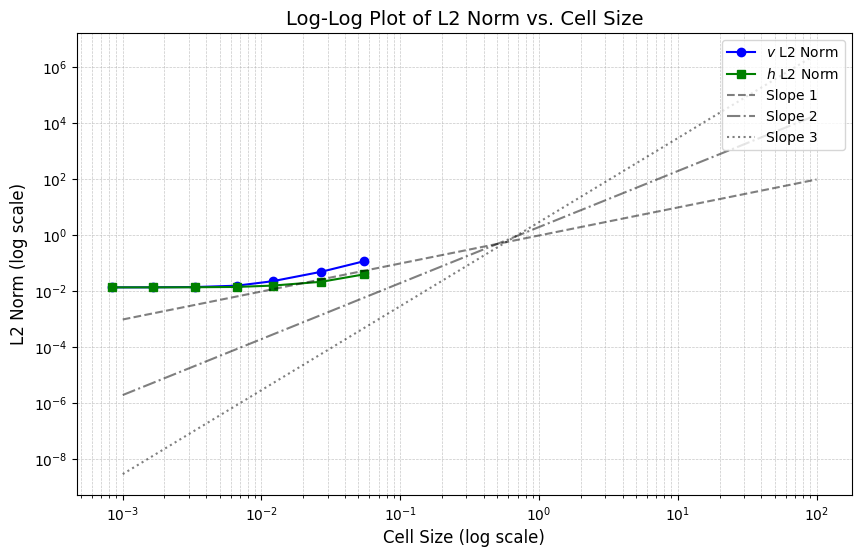

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Data
cell_size = [
    109.22818795864026, 53.957335342874, 24.02847481531693, 
    13.25678061259621, 6.586625819840943, 3.293895306251816, 1.6739275325169252
]
L2_norm_v = [
    0.11978262876368143, 0.05057678268572133, 0.023251014608755213, 
    0.016079158155093982, 0.014410337677840926, 0.014098136863675758, 0.014030880431402614
]
L2_norm_h = [
    0.04070853337396394, 0.022191733412819103, 0.016202402631671227, 
    0.014542901888417404, 0.01414303973157813, 0.01404373902647193, 0.014018300598501716
]

# Convert data to numpy arrays for log-log plotting
cell_size = np.array(cell_size)
L2_norm_v = np.array(L2_norm_v)
L2_norm_h = np.array(L2_norm_h)

# Create the log-log plot
plt.figure(figsize=(10, 6))

# Plot for velocity (v)
plt.plot(cell_size/length, L2_norm_v, marker='o', label='$v$ L2 Norm', color='blue')

# Plot for hydraulic head (h)
plt.plot(cell_size/length, L2_norm_h, marker='s', label='$h$ L2 Norm', color='green')

# Add gradient lines for theoretical slopes
x = np.linspace(1e-3, 1e2, 100)  # Create x values for slope lines
plt.plot(x, 1* x**(1), 'k--', alpha=0.5, label='Slope 1')
plt.plot(x, 2* x**(2), 'k-.', alpha=0.5, label='Slope 2')
plt.plot(x, 3* x**(3), 'k:', alpha=0.5, label='Slope 3')

# Customize plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cell Size (log scale)', fontsize=12)
plt.ylabel('L2 Norm (log scale)', fontsize=12)
plt.title('Log-Log Plot of L2 Norm vs. Cell Size', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.show()


In [87]:
# Save the plot as JPG and PDF
plt.savefig("L2_Norm_vs_Cell_Size.jpg", dpi=300, bbox_inches="tight")
plt.savefig("L2_Norm_vs_Cell_Size.pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [88]:
#h_num

In [89]:
#with meshbox.accesss():
    #print(h_num.data)

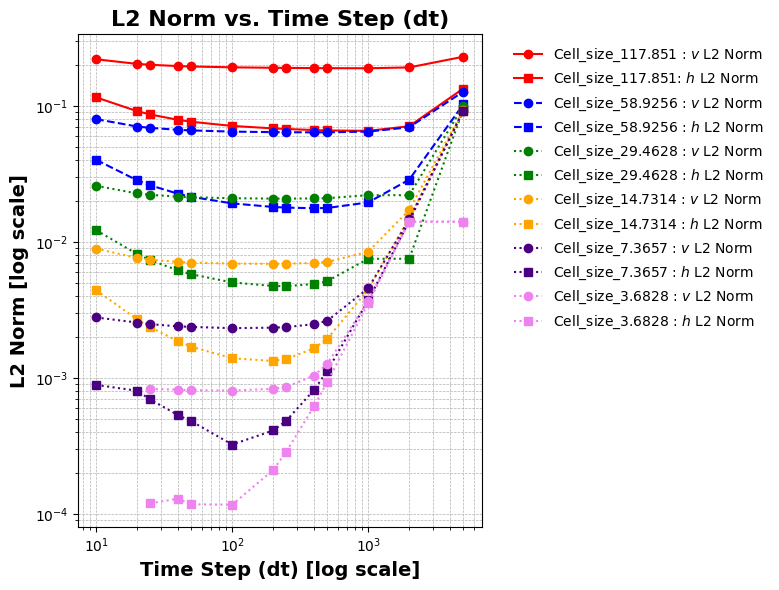

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the sets
dt = np.array([10, 20, 25, 40, 50, 100, 200, 250, 400, 500, 1000, 2000, 5000])

L2_norm_v_1 = np.array([0.22055052022593288, 0.2040311531980753, 0.2009817204228231, 0.1966083201368283, 
               0.19520343007713548, 0.1924308172136238, 0.19094432636707512, 0.1905995297415944, 
               0.18999561502016885, 0.18976241599975516, 0.18950734679373682, 0.19214497495725857, 
               0.23027102872286925])

L2_norm_h_1 = np.array([0.11579356342739587, 0.09161849548332783, 0.08666183879720908, 0.07914516044756176, 
               0.07660709834444818, 0.07138589719641002, 0.06846624173770244, 0.06778030334066318, 
               0.06657844898411301, 0.0661174742219242, 0.06565733103196768, 0.07099881554246645, 
               0.1344251733272507])

L2_norm_v_2 = np.array([0.08006043799469205,0.07068990879475291,0.06906744660241657,0.06683093929504894,0.06614175869152845,0.06484857908925094,0.06424608812586961,0.06413682520129171,0.06402950691167743,0.06405500363250734,0.0648608932358414,0.06974076938908925,0.12757402804247278])

L2_norm_h_2 = np.array([0.04020475593895644,0.02845193108621352,0.026118294771413763,0.022650265395723745,0.021505780907419562,0.019232925067195566,0.018112566876778747,0.01790875442786782,0.017728457998279594,0.01780382317408209,0.019557210428135716,0.02872787359182665,0.10293114779780992])

L2_norm_v_3 = np.array([0.025899250904251943,0.02276275760421463,0.02224885945345557,0.021563559133046646,0.0213596583740992,0.020994845855079766,0.020858019204318373,0.02085065266976462,0.02091864345276307,0.02101690249233851,0.022104819210957964,0.022104819210957964,0.10003759687766897])

L2_norm_h_3 = np.array([0.012224005796999279,0.008163851451391592,0.007364955154101141,0.00618375917829175,0.0057969412194787545,0.005048296761416497,0.004749841233151973,0.004738417824816707,0.004917968694469932,0.005160767438669803,0.007532938311010888,0.007532938311010888,0.09466175851310757])

L2_norm_v_4 = np.array([0.008951334200511129,0.007623983445429903,0.007414793961380948,0.007144929705960678,0.007068032545508458,0.006939922431458224,0.006913295213422583,0.006926755094118277,0.007024757413156358,0.007136924116181589,0.008490123862069451,0.017196578889117974,0.0937142146439266])

L2_norm_h_4 = np.array([0.004417082415336454,0.0027054834944805362,0.0023670219619547654,0.0018657035308744703,0.0017024403120877588,0.0013989349881905738,0.0013360539605049536, 0.001378498371346456,0.0016568365058199249, 0.0019450415829405673,0.00448261951100829,0.014917783547371843,0.09253338732255205])

L2_norm_v_5 = np.array([0.0027891247705868396,0.002560387,0.002489229,0.002402005,0.002378914,0.00232706,0.00234773,0.002369435,0.002491878,0.002639136,0.004573782,0.014667692,0.092295697])

L2_norm_h_5 = np.array([0.0008910379567178878,0.000806987,0.000696234,0.000533758,0.000482374,0.00032449,0.000411803,0.000486442,0.000818682,0.001128372,0.00372759,0.014238001,0.092031638])

# Reduced dt for L2_norm_v_6 and L2_norm_h_6
reduced_dt = dt[2:]
L2_norm_v_6 = np.array([0.0008326981048233787,0.000821298878996614,0.0008146030100870201,0.0008091396980434756,0.0008336161570307612,0.0008615005586533131,0.0010424470061406973,0.0012714299399330486,0.0036942615942950245,0.01415389317266769,0.01415389317266302])
L2_norm_h_6 = np.array([0.00011996324221727174,0.0001298856431592123,0.00011803416417075227,0.00011722199164161524,0.00021105349391304368,0.0002874245217067888,0.0006218130442854291,0.000935001761285142,0.00354257683884005,0.014067643341003593,0.014067643341000293])

# Plot
plt.figure(figsize=(8, 6))

# Dataset 1
plt.plot(dt, L2_norm_v_1, marker='o', label='Cell_size_117.851 : $v$ L2 Norm', color='red', linestyle='-')
plt.plot(dt, L2_norm_h_1, marker='s', label='Cell_size_117.851: $h$ L2 Norm', color='red', linestyle='-')

# Dataset 2
plt.plot(dt, L2_norm_v_2, marker='o', label='Cell_size_58.9256 : $v$ L2 Norm', color='blue', linestyle='--')
plt.plot(dt, L2_norm_h_2, marker='s', label='Cell_size_58.9256 : $h$ L2 Norm', color='blue', linestyle='--')

# Dataset 3
plt.plot(dt, L2_norm_v_3, marker='o', label='Cell_size_29.4628 : $v$ L2 Norm', color='green', linestyle=':')
plt.plot(dt, L2_norm_h_3, marker='s', label='Cell_size_29.4628 : $h$ L2 Norm', color='green', linestyle=':')

# Dataset 4
plt.plot(dt, L2_norm_v_4, marker='o', label='Cell_size_14.7314 : $v$ L2 Norm', color='orange', linestyle=':')
plt.plot(dt, L2_norm_h_4, marker='s', label='Cell_size_14.7314 : $h$ L2 Norm', color='orange', linestyle=':')

# Dataset 5
plt.plot(dt, L2_norm_v_5, marker='o', label='Cell_size_7.3657 : $v$ L2 Norm', color='indigo', linestyle=':')
plt.plot(dt, L2_norm_h_5, marker='s', label='Cell_size_7.3657 : $h$ L2 Norm', color='indigo', linestyle=':')

# Dataset 6 (with reduced dt)
plt.plot(reduced_dt, L2_norm_v_6, marker='o', label='Cell_size_3.6828 : $v$ L2 Norm', color='violet', linestyle=':')
plt.plot(reduced_dt, L2_norm_h_6, marker='s', label='Cell_size_3.6828 : $h$ L2 Norm', color='violet', linestyle=':')

# Log-log scale
plt.xscale('log')
plt.yscale('log')

# Labels and Title
plt.xlabel('Time Step (dt) [log scale]', fontsize=14, weight='bold')
plt.ylabel('L2 Norm [log scale]', fontsize=14, weight='bold')
plt.title('L2 Norm vs. Time Step (dt)', fontsize=16, weight='bold')

# Grid and Legend
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=False)

# Display the plot
plt.tight_layout()
plt.savefig("L2_Norm_vs_dt_Publication_Quality.png", dpi=300)
plt.show()